## <a name="table">Table of Contents</a> 
1. [Pre-Process Data](#PreProcess)  

2. [Use Case A:  Cluster Data about different English Leagues](#UseCaseA)  
    2.1 [Feature Selection](#UseCaseAFeatureSelection) <br />
    2.2 [Clusters Understanding](#UseCaseAClusterUnderstanding) <br />
    2.3 [Silhoutte Results](#UseCaseASilhoutteResults) <br />
    2.4 [Visualization of clusters for use case A](#UseCaseAVisualization)<br />
    2.5 [Experiment: Time To Load Cluster Visualizations](#UseCaseATimeExperiment)<br />
     
     
3. [Use Case B: Cluster traits of positions in different leagues ](#UseCaseB)  
    3.1 [Feature Selection](#UseCaseBFeatureSelection)<br />
    3.2 [Clusters Understanding](#UseCaseBClusterUnderstanding)<br />
    3.3 [Silhoutte Results](#UseCaseBSilhoutteResults)<br />
    3.4 [Visualization of clusters for use case B](#UseCaseBVisualization)<br />
    3.5 [Experiment: Time To Load Cluster Visualizations](#UseCaseBTimeExperiment)<br />


## <a name="PreProcess"> 1. Pre-Processing Data</a>

In [11]:
# Import packages for clustering, processing data, dimensionality management and visualizing.
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from matplotlib.pyplot import figure
from pyclustertend import hopkins
from scipy import stats
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.tree import _tree, DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import folium
from folium import IFrame
import io
import sys



In [12]:
football_teams_gk_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet1_Teams_Gk_Stats")
football_teams_df_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet2_Teams_DF_Stats")
football_teams_mf_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet3_Teams_Midfielder_Stats")
football_teams_fw_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet4_Teams_Forward_Stats")

In [13]:
football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")

In [1]:
def getLongitude(x):
    x = x.replace('[', '')
    x = x.replace(']', '')
    #print("x is: ",x)
    if "," in x:
        x_list = x.split(',')
        return x_list[0] 
    else:
        return x
    
def getLatitude(x):
    x = x.replace('[', '')
    x = x.replace(']', '')
    #print("x is: ",x)
    if "," in x:
        x_list = x.split(',')
        return x_list[0] 
    else:
        return x
    
def getHeight(x):
    x = float(x)
    if x > 100:
        x = x/100
    
    if x > 1.5 and x < 2.2:
        return x
    else:
        return None

def getClubCaps(x):
    x = float(x)
    if x > 20.0:
        return x
    else:
        return None
    
def getProperPositions(x):
    try:
        x = float(x)
        return x
    except ValueError:
        return None   
    
def addColumnsForFWClubCaps(football_teams_df):
    football_teams_df["fwclubcaps"] = football_teams_df["fwclubcaps"].apply(getClubCaps)
    football_teams_df = football_teams_df[pd.to_numeric(football_teams_df['fwclubcaps'], errors='coerce').notnull()]
    return football_teams_df

def addColumnsForMFClubCaps(football_teams_df):
    football_teams_df["mfclubcaps"] = football_teams_df["mfclubcaps"].apply(getClubCaps)
    football_teams_df = football_teams_df[pd.to_numeric(football_teams_df['mfclubcaps'], errors='coerce').notnull()]
    return football_teams_df

def addColumnsForLeague(football_teams_df):
    dataset_column_length = len(football_teams_df.columns)

    leaguesIndex = []
    leagues = ["premier_league","championship","leagueone"]

    for i in range(len(leagues)):
        leaguesIndex.append((i+1,leagues[i]))
        
    for league in leagues:
        football_teams_df["League_"+ league]=football_teams_df["league"].map(lambda x: league == x)
        
    football_teams_df.iloc[:,dataset_column_length:] = football_teams_df.iloc[:,dataset_column_length:].astype(int)
    football_teams_df = football_teams_df.drop('league', 1)
    return football_teams_df
    
def addColumnsForLatitude(football_teams_df):
    football_teams_df["latitude"] = football_teams_df["latitude"].apply(getLatitude)
    return football_teams_df

def addColumnsForLeagueResult(football_teams_df):
    football_teams_df["leagueResult"] = football_teams_df["leagueResult"].apply(getProperPositions)
    football_teams_df = football_teams_df[pd.to_numeric(football_teams_df['leagueResult'], errors='coerce').notnull()]

    return football_teams_df

def addColumnsForLongitude(football_teams_df):
    football_teams_df["longitude"] = football_teams_df["longitude"].apply(getLongitude)
    return football_teams_df

def addColumnsForFWHeight(football_teams_df):
    football_teams_df["fwheight"] = football_teams_df["fwheight"].apply(getHeight)
    football_teams_df = football_teams_df[pd.to_numeric(football_teams_df['fwheight'], errors='coerce').notnull()]
    return football_teams_df

def addColumnsForMFHeight(football_teams_df):
    football_teams_df["mfheight"] = football_teams_df["mfheight"].apply(getHeight)
    football_teams_df = football_teams_df[pd.to_numeric(football_teams_df['mfheight'], errors='coerce').notnull()]
    return football_teams_df

def edit_data_frame_with_columns_mf(lst_of_features,football_teams_df):
    if 'clubname' not in lst_of_features:
        football_teams_df = football_teams_df.drop('clubname', 1)
        

    if 'longitude' in lst_of_features:
        football_teams_df = addColumnsForLongitude(football_teams_df)
    
    else:
        football_teams_df = football_teams_df.drop('longitude', 1)
    
    
    if 'latitude' in lst_of_features:
        football_teams_df = addColumnsForLatitude(football_teams_df)
    
    else:
        football_teams_df = football_teams_df.drop('latitude', 1)

    if 'league' in lst_of_features:  
        football_teams_df = addColumnsForLeague(football_teams_df)
    else:
        football_teams_df = football_teams_df.drop('league', 1)
        
    if 'leagueResult' in lst_of_features:  
        football_teams_df = addColumnsForLeagueResult(football_teams_df)
    else:
        football_teams_df = football_teams_df.drop('leagueResult', 1)
        
    if 'capacity' not in lst_of_features:  
        football_teams_df = football_teams_df.drop('capacity', 1)
        
    if 'mfheight' in lst_of_features:  
        football_teams_df = addColumnsForMFHeight(football_teams_df)
    else:
        football_teams_df = football_teams_df.drop('mfheight', 1)
     
    if 'mfbirthDate' not in lst_of_features:  
        football_teams_df = football_teams_df.drop('mfbirthDate', 1)
    
    if 'mfnationalcaps' not in lst_of_features: 
        football_teams_df = football_teams_df.drop('mfnationalcaps', 1)
    
    if 'mfclubcaps' in lst_of_features: 
        football_teams_df = addColumnsForMFClubCaps(football_teams_df)
    else:
        football_teams_df = football_teams_df.drop('mfclubcaps', 1)
        
    return football_teams_df


def edit_data_frame_with_columns_fw(lst_of_features,football_teams_df):
    if 'clubname' not in lst_of_features:
        football_teams_df = football_teams_df.drop('clubname', 1)

    if 'longitude' in lst_of_features:
        football_teams_df = addColumnsForLongitude(football_teams_df)
    else:
        football_teams_df = football_teams_df.drop('longitude', 1)
    if 'latitude' in lst_of_features:
        football_teams_df = addColumnsForLatitude(football_teams_df)
    else:
        football_teams_df = football_teams_df.drop('latitude', 1)

    if 'league' in lst_of_features:  
        football_teams_df = addColumnsForLeague(football_teams_df)
    else:
        football_teams_df = football_teams_df.drop('league', 1)
        
    if 'leagueResult' not in lst_of_features:  
        football_teams_df = football_teams_df.drop('leagueResult', 1)
    if 'capacity' not in lst_of_features:  
        football_teams_df = football_teams_df.drop('capacity', 1)
    if 'fwheight' in lst_of_features:  
        football_teams_df = addColumnsForFWHeight(football_teams_df)
    else:
        football_teams_df = football_teams_df.drop('fwheight', 1)
    if 'fwbirthDate' not in lst_of_features:  
        football_teams_df = football_teams_df.drop('fwbirthDate', 1)
    if 'fwnationalcaps' not in lst_of_features: 
        football_teams_df = football_teams_df.drop('fwnationalcaps', 1)
    if 'fwclubcaps' in lst_of_features: 
        football_teams_df = addColumnsForFWClubCaps(football_teams_df)
    else:
        football_teams_df = football_teams_df.drop('fwclubcaps', 1)
    return football_teams_df


def find_largest_silhoutte_score_for_features(lst_of_features,football_teams_df,cosine_distance,forwards=True):
    if forwards == True:
        football_teams_df = edit_data_frame_with_columns_fw(lst_of_features,football_teams_df)
    else:
        football_teams_df = edit_data_frame_with_columns_mf(lst_of_features,football_teams_df)
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(football_teams_df), columns=football_teams_df.columns)
    data_scaled.head()
    distance_metric = 'euclidean'
    linkage_types = ['ward','average','complete']
    if cosine_distance == True:
        distance_metric = 'cosine'
        linkage_types = ['average','complete','single']
    max_clusters = 0
    if len(football_teams_df.index) > 17:
        max_clusters = 17
    else:
        max_clusters = int(len(football_teams_df.index)/2)
    silhoutte_scores = []
    for link in linkage_types:
        for i in range(2,max_clusters):
            cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=link) 
            model = cluster.fit_predict(data_scaled)
            hierarchical_clustering = pd.DataFrame(model)
            silhoutte_scores.append((link,i,silhouette_score(data_scaled,hierarchical_clustering[0],metric='euclidean')))
    silhoutte_scores.sort(key=lambda x:x[2]) #Order elements by the Silhoutte Score
    return silhoutte_scores[-1]



def find_best_features(lst,num_features,football_teams_df,cosine_distance,forwards=True):
    largest_element = None
    players_df = football_teams_df.copy()
    i = 0
    current_elements = []
    optimal_num_cluster = 0
    optimal_link_type = ""
    while i < num_features:
        max_shil_score = 0
        largest_element = 0
        for items in lst:
            test_players_df = players_df.copy()
            new_lst = current_elements + [items]
            link, num_clusters ,score = find_largest_silhoutte_score_for_features(new_lst,test_players_df,cosine_distance,forwards)
            if score > max_shil_score:
                largest_element = items
                max_shil_score = score
                optimal_num_cluster = num_clusters
                optimal_link_type = link
        current_elements.append(largest_element)
        lst.remove(largest_element)
        i += 1
    return ((current_elements,optimal_link_type, optimal_num_cluster,max_shil_score))



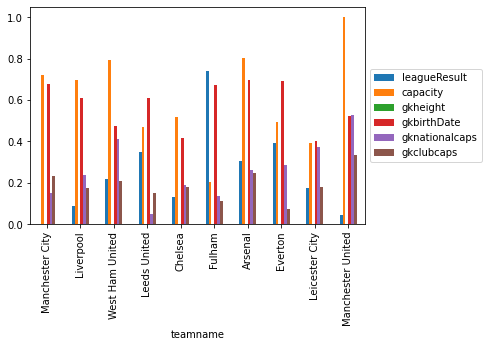

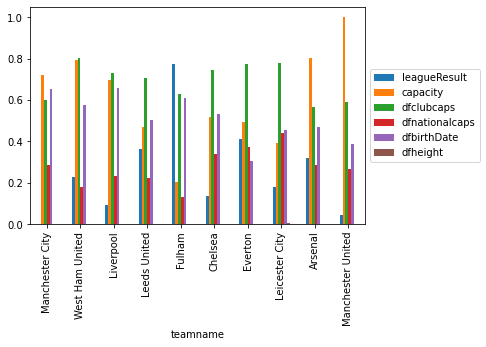

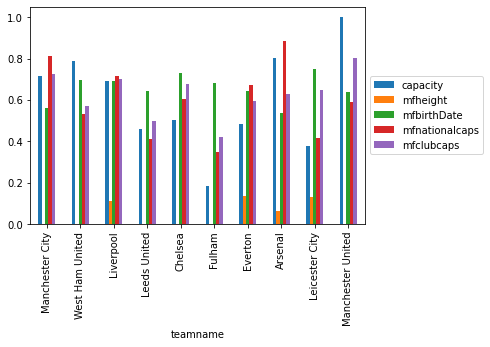

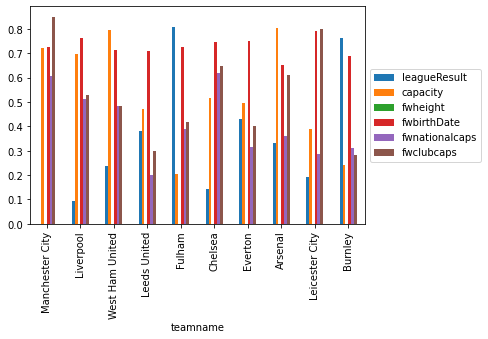

In [5]:
gk_df = football_teams_gk_df.copy()
def_df = football_teams_df_df.copy()
mf_df = football_teams_mf_df.copy()
fw_df = football_teams_fw_df.copy()
scaler = MinMaxScaler()
gk_id = gk_df.iloc[0:10,0]
gk_df = gk_df.drop('clubname', 1)
gk_df = gk_df.drop('league', 1)
gk_df = gk_df.drop('longitude', 1)
gk_df = gk_df.drop('latitude', 1)
gkColumns = gk_df.columns
football_teams_with_gk_cateogries_df = pd.DataFrame(scaler.fit_transform(gk_df))
football_teams_with_gk_cateogries_df.columns = gkColumns
football_teams_with_gk_cateogries_df = football_teams_with_gk_cateogries_df.iloc[0:10,:]
football_teams_with_gk_cateogries_df["teamname"] = gk_id.values
plot1 = football_teams_with_gk_cateogries_df.plot.bar(x = "teamname")
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig1 = plot1.get_figure()
fig1.savefig('FootballTeamData1.png', dpi=300, bbox_inches='tight')
def_id = def_df.iloc[0:10,0]
def_df = def_df.drop('clubname', 1)
def_df = def_df.drop('league', 1)
def_df = def_df.drop('longitude', 1)
def_df = def_df.drop('latitude', 1)
defColumns = def_df.columns
football_teams_with_def_cateogries_df = pd.DataFrame(scaler.fit_transform(def_df))
football_teams_with_def_cateogries_df.columns = defColumns
football_teams_with_def_cateogries_df = football_teams_with_def_cateogries_df.iloc[0:10,:]
football_teams_with_def_cateogries_df["teamname"] = def_id.values
plot2=football_teams_with_def_cateogries_df.plot.bar(x = "teamname")
plot2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig2 = plot2.get_figure()
fig2.savefig('FootballTeamData2.png', dpi=300, bbox_inches='tight')
mf_id = mf_df.iloc[0:10,0]
mf_df = mf_df.drop('clubname', 1)
mf_df = mf_df.drop('league', 1)
mf_df = mf_df.drop('longitude', 1)
mf_df = mf_df.drop('latitude', 1)
mf_df = mf_df.dropna()
mf_df = mf_df.set_index("leagueResult")
mf_df = mf_df.drop("Preseason", axis=0)
mfColumns = mf_df.columns
football_teams_with_mf_cateogries_df = pd.DataFrame(scaler.fit_transform(mf_df))
football_teams_with_mf_cateogries_df.columns = mfColumns
football_teams_with_mf_cateogries_df = football_teams_with_mf_cateogries_df.iloc[0:10,:]
football_teams_with_mf_cateogries_df["teamname"] = mf_id.values
plot3=football_teams_with_mf_cateogries_df.plot.bar(x = "teamname")
plot3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig3 = plot3.get_figure()
fig3.savefig('FootballTeamData3.png', dpi=300, bbox_inches='tight')
fw_id = fw_df.iloc[0:10,0]
fw_df = fw_df.drop('clubname', 1)
fw_df = fw_df.drop('league', 1)
fw_df = fw_df.drop('longitude', 1)
fw_df = fw_df.drop('latitude', 1)
fwColumns = fw_df.columns
football_teams_with_fw_cateogries_df = pd.DataFrame(scaler.fit_transform(fw_df))
football_teams_with_fw_cateogries_df.columns = fwColumns
football_teams_with_fw_cateogries_df = football_teams_with_fw_cateogries_df.iloc[0:10,:]
football_teams_with_fw_cateogries_df["teamname"] = fw_id.values
plot4=football_teams_with_fw_cateogries_df.plot.bar(x = "teamname")
plot4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig4 = plot4.get_figure()
fig4.savefig('FootballTeamData4.png', dpi=300, bbox_inches='tight')



## <a name="UseCaseA">2. Use Case A: Cluster Data about different English Leagues </a>

### <a name="UseCaseAFeatureSelection">2.1. FeatureSelection</a> 
[Back to Table of Contents](#table)

In [15]:
football_teams_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet4_Teams_Forward_Stats")
print(find_best_features(['leagueResult','league','capacity','fwheight','fwbirthDate','fwnationalcaps','fwclubcaps'],4,football_teams_df,False,True))


(['league', 'fwbirthDate', 'fwnationalcaps', 'capacity'], 'complete', 3, 0.7169851203597429)


Normalizing The Data

In [16]:
football_teams_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet4_Teams_Forward_Stats")
football_teams_df = edit_data_frame_with_columns_fw(['league', 'fwbirthDate', 'fwnationalcaps', 'capacity'],football_teams_df)
df1_football_teams = football_teams_df
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(football_teams_df), columns=football_teams_df.columns)
data_scaled.head()

,capacity,fwbirthDate,fwnationalcaps,League_premier_league,League_championship,League_leagueone
0,0.721604,0.723625,0.604651,1.0,0.0,0.0
1,0.697976,0.764034,0.513417,1.0,0.0,0.0
2,0.794148,0.715210,0.485465,1.0,0.0,0.0
3,0.470840,0.708517,0.199336,1.0,0.0,0.0
4,0.202489,0.726684,0.389535,1.0,0.0,0.0


##### Identifying and removing outliers

In [17]:
data_scaled[(np.abs(stats.zscore(data_scaled)) < 3).all(axis=1)]

,capacity,fwbirthDate,fwnationalcaps,League_premier_league,League_championship,League_leagueone
0,0.721604,0.723625,0.604651,1.0,0.0,0.0
1,0.697976,0.764034,0.513417,1.0,0.0,0.0
2,0.794148,0.715210,0.485465,1.0,0.0,0.0
3,0.470840,0.708517,0.199336,1.0,0.0,0.0
4,0.202489,0.726684,0.389535,1.0,0.0,0.0
5,0.515126,0.746424,0.617940,1.0,0.0,0.0
6,0.494453,0.752023,0.315891,1.0,0.0,0.0
7,0.804397,0.651189,0.359173,1.0,0.0,0.0
8,0.390319,0.790939,0.286822,1.0,0.0,0.0
9,0.240122,0.687471,0.309302,1.0,0.0,0.0


##### Testing to determine the clustering tendency of a data set.

In [18]:
hopkins(df1_football_teams,len(df1_football_teams))

0.48660897797934904

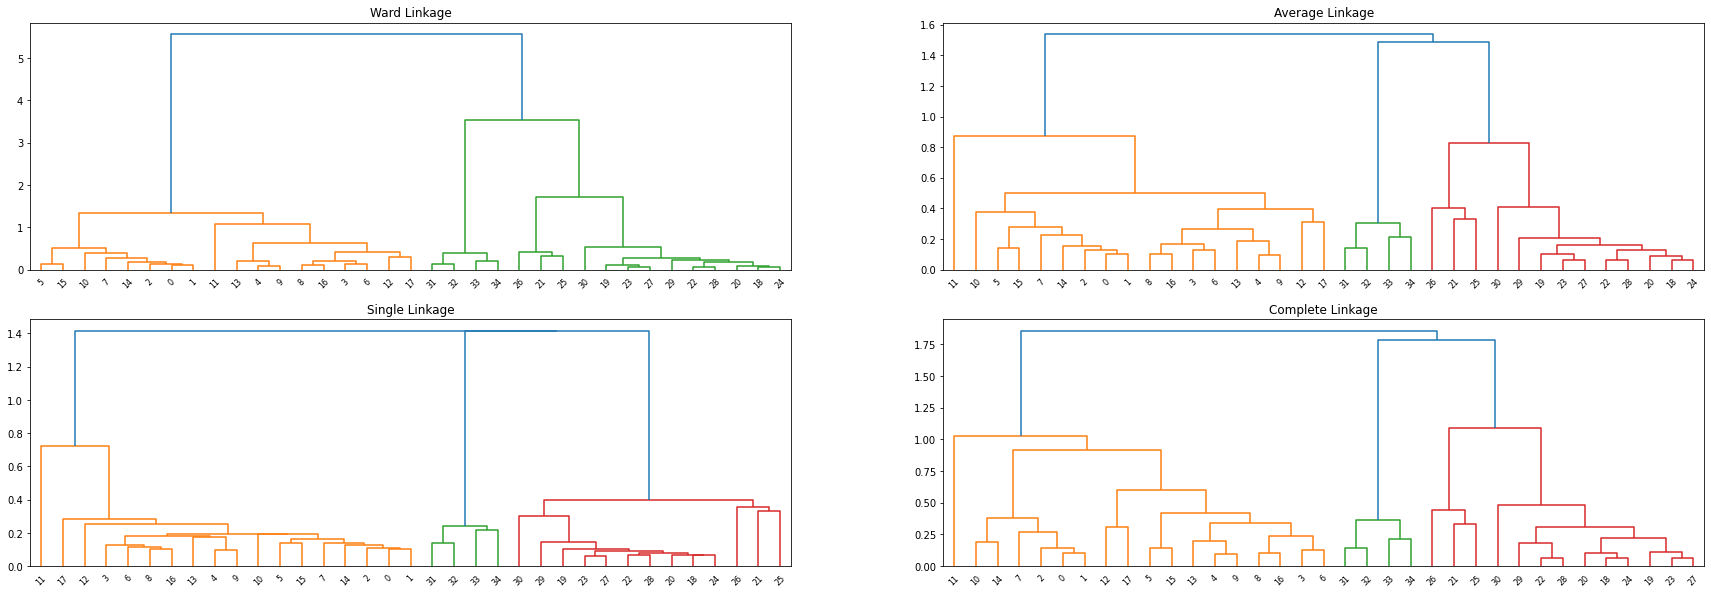

In [19]:
import scipy.cluster.hierarchy as shc
rows = 2
columns = 2
figure = plt.figure(figsize=(30, 10))  
figure.add_subplot(rows, columns, 1)
plt.title("Ward Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='ward'))
figure.add_subplot(rows, columns, 2)
plt.title("Average Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='average'))
figure.add_subplot(rows, columns, 3)
plt.title("Single Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='single'))
figure.add_subplot(rows, columns, 4)
plt.title("Complete Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='complete'))
figure.savefig('DendogramsFotoTeamsA1.png', dpi=300, bbox_inches='tight')

## Applying Hierarchical clustering for the clusters

In [20]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
team_models = cluster.fit_predict(data_scaled)

### <a name="UseCaseAClusterUnderstanding">2.2 Feature Selection and Understanding Clusters</a> 
[Back to Table of Contents](#table)

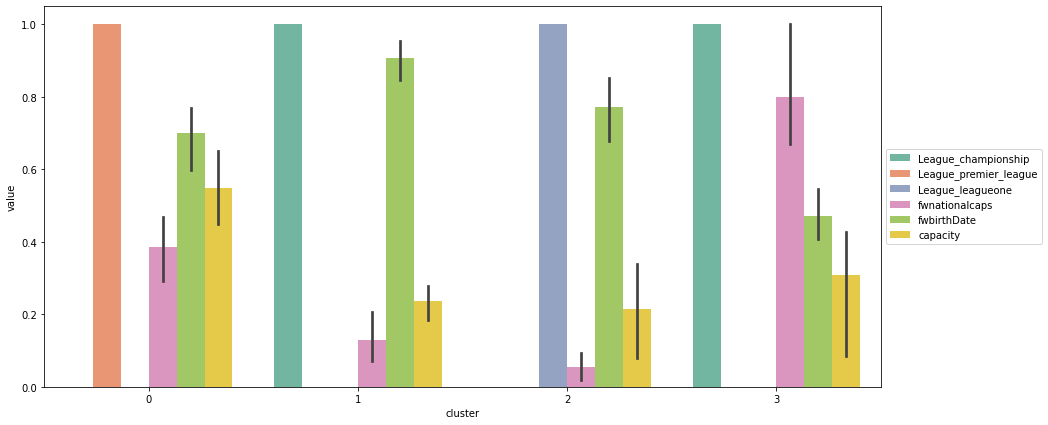

In [21]:
# Grouping rows of data based on Hierarchical cluster
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
minMaxscaler = MinMaxScaler()
scaledDataFrame = pd.DataFrame(minMaxscaler.fit_transform(df1_football_teams))
scaledDataFrame.columns = df1_football_teams.columns
scaledDataFrame['cluster'] = cluster.labels_
meansDataFrame = scaledDataFrame.groupby('cluster').mean().reset_index()
variablesDeviations = pd.DataFrame(columns=['Vars', 'Deviation'])
i = 0
while i < len(meansDataFrame.columns[1:]):
    variablesDeviations.loc[len(variablesDeviations), :] = [meansDataFrame.columns[1:][i], np.std(meansDataFrame[meansDataFrame.columns[1:][i]])]
    i+=1
includedColumns = list(variablesDeviations.sort_values('Deviation', ascending=False).head(10).Vars.values) + ['cluster']
finalData = scaledDataFrame[includedColumns].melt(id_vars='cluster')
figure, axix = plt.subplots(figsize=(15, 7))
sns.barplot(x='cluster', y='value', hue='variable', data=finalData, palette='Set2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('clustersFromFootTeamsA.png', dpi=300, bbox_inches='tight')

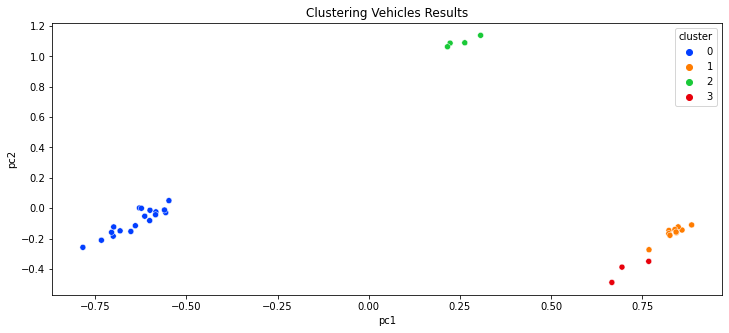

In [22]:
from sklearn.decomposition import PCA
fig, (sub1) = plt.subplots(1, figsize=(12, 5))
pca_vehicle_data = PCA(n_components=2)
principalComponents_vehicles = pca_vehicle_data.fit_transform(data_scaled)
sns.scatterplot(x=principalComponents_vehicles[:,0], y=principalComponents_vehicles[:,1], hue=team_models, palette='bright',ax=sub1);
sub1.set(xlabel="pc1", ylabel="pc2", title="Clustering Vehicles Results")
sub1.legend(title='cluster');
fig.savefig('PCAFootTeamsA1.png', dpi=300, bbox_inches='tight')

### <a name="UseCaseASilhoutteResults">2.3 Analysing Cluster Results with Different linkage criteria and number of clusters</a> 
[Back to Table of Contents](#table)

In [23]:
sil_scores = []
dav_scores = []
calin_scores = []
n_clusters = []
for i in range(2,20):
    cluster1 = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='complete')  
    team_models1 = cluster1.fit_predict(data_scaled)
    hierarchical_clustering = pd.DataFrame(team_models1)
    dav_scores.append(davies_bouldin_score(data_scaled,hierarchical_clustering[0]))
    sil_scores.append(silhouette_score(data_scaled,hierarchical_clustering[0],metric='euclidean'))
    calin_scores.append(calinski_harabasz_score(data_scaled,hierarchical_clustering[0]))
    n_clusters.append(i)    
hierarchicial_clustering_results_df = {'Num Clusters': n_clusters,'Silhouette Score': sil_scores, 'Davies Bouldin Score': dav_scores,'Calinski Harabasz Score': calin_scores}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  Num Clusters &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0  &             2 &          0.586212 &              0.705931 &                48.929670 \\
1  &             3 &          0.716985 &              0.407853 &                84.206323 \\
2  &             4 &          0.710871 &              0.383856 &                90.558638 \\
3  &             5 &          0.614583 &              0.366694 &                89.349872 \\
4  &             6 &          0.553348 &              0.483255 &               118.216135 \\
5  &             7 &          0.529207 &              0.544566 &               117.594857 \\
6  &             8 &          0.452856 &              0.536196 &               114.302447 \\
7  &             9 &          0.443521 &              0.512557 &               108.150033 \\
8  &            10 &          0.407636 &              0.526841 &               111.587237 \\
9  &            11 &         

In [24]:
cluster1 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
team_models1 = cluster1.fit_predict(data_scaled)
hierarchical_clustering1 = pd.DataFrame(team_models1)
davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering1[0])
silhouette_score1 = silhouette_score(data_scaled,hierarchical_clustering1[0],metric='euclidean')
calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering1[0])

cluster2 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')  
team_models2 = cluster2.fit_predict(data_scaled)
hierarchical_clustering2 = pd.DataFrame(team_models2)
davies_bouldin_score2 = davies_bouldin_score(data_scaled,hierarchical_clustering2[0])
silhouette_score2 = silhouette_score(data_scaled,hierarchical_clustering2[0],metric='euclidean')
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,hierarchical_clustering2[0])

cluster3 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
team_models3 = cluster3.fit_predict(data_scaled)
hierarchical_clustering3 = pd.DataFrame(team_models3)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,hierarchical_clustering3[0])
silhouette_score3 = silhouette_score(data_scaled,hierarchical_clustering3[0],metric='euclidean')
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,hierarchical_clustering3[0])

cluster4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='single') 
team_models4 = cluster4.fit_predict(data_scaled)
hierarchical_clustering4 = pd.DataFrame(team_models4)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,hierarchical_clustering4[0])
silhouette_score4 = silhouette_score(data_scaled,hierarchical_clustering4[0],metric='euclidean')
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,hierarchical_clustering4[0])

hierarchicial_clustering_results_df = {'Linkage Type': ['Ward','Average','Complete','Single'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{llrrr}
\toprule
{} & Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &         Ward &          0.710871 &              0.383856 &                90.558638 \\
1 &      Average &          0.618429 &              0.378325 &                66.385918 \\
2 &     Complete &          0.710871 &              0.383856 &                90.558638 \\
3 &       Single &          0.618429 &              0.378325 &                66.385918 \\
\bottomrule
\end{tabular}



#### Determining the number of clusters for K-means Algorithm using Silhouette Visualizer

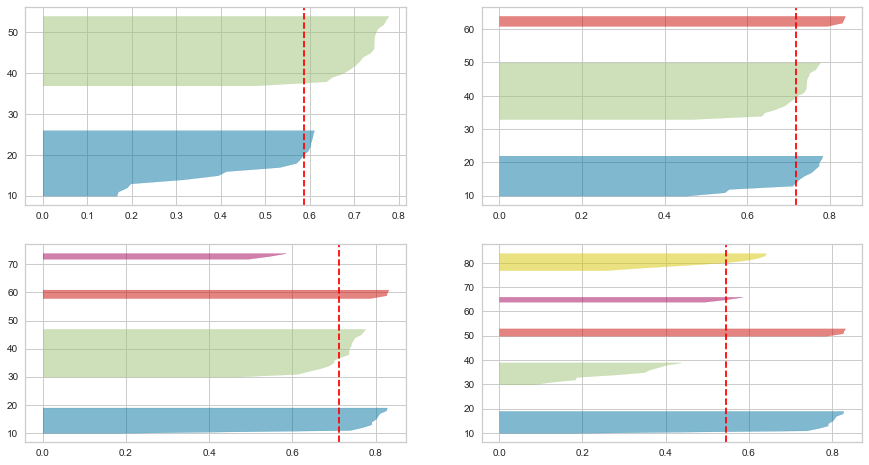

In [25]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled)

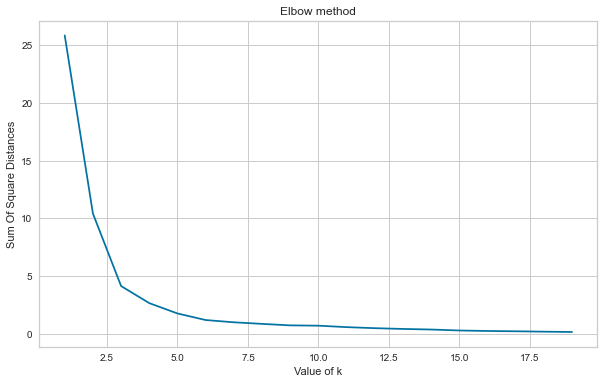

In [26]:
#Using Elbow Method when num clusters > 5
sum_of_squared_distances = []
cluster_range = range(1,20)
for cluster_num in cluster_range:
    kModel = KMeans(n_clusters=cluster_num)
    kModel.fit(data_scaled)
    sum_of_squared_distances.append(kModel.inertia_)
plt.figure(figsize=(10,6))
plt.plot(cluster_range, sum_of_squared_distances, 'bx-')
plt.xlabel('Value of k')
plt.ylabel('Sum Of Square Distances')
plt.title('Elbow method')
plt.show()

#### Criteria for DBSCAN

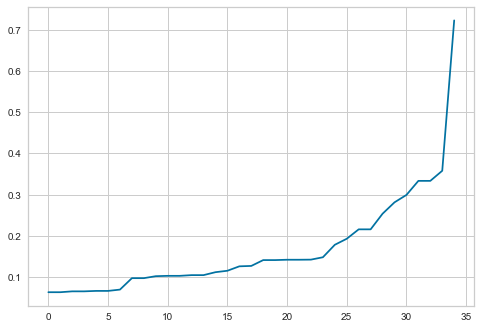

In [27]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#### Comparing the cell types

In [28]:
#Hierarchical clustering, K-means clustering with cosine k-means, .....
kmeans_norm = KMeans(n_clusters=3).fit(data_scaled)
dbs_data = DBSCAN(eps=0.30, min_samples=2).fit(data_scaled)

silhouette_score1 = silhouette_score(data_scaled, hierarchical_clustering3[0],metric='euclidean')
silhouette_score2 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='euclidean')
silhouette_score3 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='cosine')
silhouette_score4 = silhouette_score(data_scaled, dbs_data.labels_)

davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering3[0])
davies_bouldin_score2 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,dbs_data.labels_)

calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering3[0])
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,dbs_data.labels_)

clustering_results_df = {'Linkage Type': ['Agglomerative Hierarchical clustering(linkage = Average)','Kmeans','Cosine Based Kmeans','DBSCAN'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_of_results = pd.DataFrame(clustering_results_df)  
print(df_of_results.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &                                       Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &  Agglomerative Hierarchical clustering(linkage ... &          0.710871 &              0.383856 &                90.558638 \\
1 &                                             Kmeans &          0.716985 &              0.407853 &                84.206323 \\
2 &                                Cosine Based Kmeans &          0.901042 &              0.407853 &                84.206323 \\
3 &                                             DBSCAN &          0.656833 &              0.819474 &                55.340110 \\
\bottomrule
\end{tabular}



#### Latex Table of Rules For Clusters

In [29]:


dct_of_clusters = {"cluster numbers":[1,2,3,4],"cluster descriptions":["Premier League Teams", 
 "Championship Teams with average BirthYear younger than 1990",
 "League one teams",
 "Championship Teams with an average birth Year that is older than 1990"]
}


df_of_results = pd.DataFrame(dct_of_clusters)  
print(df_of_results.to_latex())



\begin{tabular}{lrl}
\toprule
{} &  cluster numbers &                               cluster descriptions \\
\midrule
0 &                1 &                               Premier League Teams \\
1 &                2 &  Championship Teams with average BirthYear youn... \\
2 &                3 &                                   League one teams \\
3 &                4 &  Championship Teams with an average birth Year ... \\
\bottomrule
\end{tabular}



### <a name="UseCaseAVisualization">2.4 Visualization of clusters for use case A</a> 
[Back to Table of Contents](#table)


In [7]:
import io
import sys
import folium
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWebEngineWidgets import QWebEngineView 
from PyQt5.QtWebEngineWidgets import QWebEngineSettings as QWebSettings
from folium import IFrame
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import collections, numpy
from matplotlib import animation
from pyclustertend import hopkins
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import folium

class Window(QtWidgets.QMainWindow):
    def __init__(self,dataset):
        self._dataset = dataset
        self._df_including_cordinates = self._dataset.copy()
        self._dataset.drop('longitude', inplace=True, axis=1)
        self._dataset.drop('latitude', inplace=True, axis=1)
        self._dataset.drop('clubname', inplace=True, axis=1)
        super().__init__()
        self.initWindow()

    def initWindow(self):
        self.setWindowTitle(self.tr("Football Team Clusters For Forwards-"))
        self.setFixedSize(1500, 800)
        self.comboBox1 = QtWidgets.QComboBox(self)
        self.editField2 = QtWidgets.QLineEdit(self)
        self.editField3 = QtWidgets.QLineEdit(self)
        self.editField4 = QtWidgets.QLineEdit(self)
        self.label5 = QtWidgets.QLabel('red',self)
        self.label5.setHidden(True)
        self.m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
        self.buttonUI()

    def buttonUI(self):
        submitButton = QtWidgets.QPushButton(self.tr("Submit"))
        submitButton.clicked.connect(self.calculateClusterPressed)
        self.comboBox1.setFixedSize(120, 50)
        self.comboBox1.addItem("Premier League")
        self.comboBox1.addItem("Championship")
        self.comboBox1.addItem("League One")
        self.editField2.setFixedSize(120, 50)
        self.editField3.setFixedSize(120, 50)
        self.editField4.setFixedSize(120, 50)
        submitButton.move(20, 260)
        label1 = QtWidgets.QLabel(self)
        label1.setText("League:")
        label1.setFixedSize(120, 50)
        label2 = QtWidgets.QLabel(self)
        label2.setText("Forward's Birth Date:")
        label2.setFixedSize(120, 50)
        label3 = QtWidgets.QLabel(self)
        label3.setText("National Caps:")
        label3.setFixedSize(120, 50)
        label4 = QtWidgets.QLabel(self)
        label4.setText("Capacity:")
        label4.setFixedSize(120, 50)
        self.label5.setText("Data is an outlier")
        self.label5.setFixedSize(120, 50)
        self.label5.setStyleSheet("background-color: red")
        self.view = QWebEngineView()
        self.view.setContentsMargins(50, 50, 50, 50)
        central_widget = QtWidgets.QWidget()
        self.setCentralWidget(central_widget)
        lay = QtWidgets.QHBoxLayout(central_widget)
        button_container = QtWidgets.QWidget()
        vlay = QtWidgets.QVBoxLayout(button_container)
        vlay.setSpacing(20)
        vlay.addStretch()
        vlay.addWidget(label1)
        vlay.addWidget(self.comboBox1)
        vlay.addWidget(label2)
        vlay.addWidget(self.editField2)
        vlay.addWidget(label3)
        vlay.addWidget(self.editField3)
        vlay.addWidget(label4)
        vlay.addWidget(self.editField4)
        vlay.addWidget(submitButton)
        vlay.addWidget(self.label5)
        vlay.addStretch()
        lay.addWidget(button_container)
        lay.addWidget(self.view, stretch=1)
        data = io.BytesIO()
        self.m.save(data, close_file=False)
        self.view.setHtml(data.getvalue().decode())
    
    def calculateClusterPressed(self):        
        current_league = str(self.comboBox1.currentText())
        if current_league == "Premier League":
            prem_value = 1.0
            league_one = 0.0
            championship = 0.0
        elif current_league == "Championship":
            prem_value = 0.0
            league_one = 0.0
            championship = 1.0
        else:
            prem_value = 0.0
            league_one = 1.0
            championship = 0.0
        insertData = {'League_premier_league':prem_value, 'League_championship':championship,'League_leagueone':league_one,'fwbirthDate':self.editField2.text(),
                       'fwnationalcaps':self.editField3.text(), 'capacity':self.editField4.text() }
        self._dataset = self._dataset.append(insertData, ignore_index=True)
        df1_football_players = football_players_df
        scaler = MinMaxScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(self._dataset), columns=self._dataset.columns)
        cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
        team_models = cluster.fit_predict(data_scaled)
        hierarchical_clustering = pd.DataFrame(team_models)
        dct_of_colour =  {0:"red", 1:"green",2:"blue",3:"orange"}
        new_item_cluster = team_models[-1]
        if np.count_nonzero(team_models == new_item_cluster) == 1:
            self.label5.setHidden(False)            
        else:
            self.label5.setHidden(True)
            i = 0
            for index, row in self._df_including_cordinates.iterrows():
                if hierarchical_clustering[0][i] == team_models[-1]:
                    html="""
                    <h1>""" + str(row['clubname']) + """'s data</h1><br>
                    <b> Club Name: </b> """ + str(row['clubname']) + """ <br>
                    <b> League: </b> """ + current_league + """ <br>
                    <b> Stadium Capacity: </b> """ +  str(row['capacity']) + """ <br>
                    <b> Forwards' Average Birth Date: </b> """ + str(row['fwbirthDate']) + """ <br>
                    <b> Forwards' Average National Caps: </b> """ + str(row['fwnationalcaps']) + """ <br>
                    """

                    frame = IFrame(html=html, width=500, height=300)
                    pop_text = folium.Popup(frame, max_width=2650)
                    folium.Marker(
                    [row['latitude'], row['longitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(self.m)
                i += 1
                self.m
                data = io.BytesIO()
                self.m.save(data, close_file=False)
                self.view.setHtml(data.getvalue().decode())
        
        
if __name__ == "__main__":
    football_teams_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet4_Teams_Forward_Stats")
    df1_football_players = edit_data_frame_with_columns_fw(['clubname','latitude','longitude','league', 'fwbirthDate', 'fwnationalcaps', 'capacity'],football_teams_df)
    App = QtCore.QCoreApplication.instance()
    if App is None:
        App = QtWidgets.QApplication(sys.argv)
    window = Window(df1_football_players)
    window.show()
    sys.exit(App.exec())


SystemExit: 0

/Users/colmclery/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### <a name="UseCaseATimeExperiment">2.5 Experimenting Time To Load Cluster items</a> 
[Back to Table of Contents](#table)

In [30]:
import time
num_clusters = 4
affin = 'euclidean'
link = 'complete'
football_teams_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet4_Teams_Forward_Stats")
df1_football_teams = edit_data_frame_with_columns_fw(['clubname','latitude','longitude','league', 'fwbirthDate', 'fwnationalcaps', 'capacity'],football_teams_df)
df1_football_teams_copy = df1_football_teams.copy()
df1_football_teams.drop('longitude', inplace=True, axis=1)
df1_football_teams.drop('latitude', inplace=True, axis=1)
df1_football_teams.drop('clubname', inplace=True, axis=1)
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df1_football_teams), columns=df1_football_teams.columns)
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity=affin, linkage=link) 
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
data_scaled.insert((data_scaled.shape[1]),'agglomerative',hierarchical_clustering)
dct_of_colour =  {0:"red", 1:"green",2:"blue",3:"orange"}    
times_dct = {"Cluster ID":[],"Number Of Teams":[],"Time To Load":[],}
m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)

cluster_id = 0
for cluster in range(num_clusters):
    i = 0
    t1 = time.time()
    count_per_cluster = 0
    for index, row in df1_football_teams_copy.iterrows():                       
        if team_models[i] == cluster_id:
            count_per_cluster += 1
            html="""
                    <h1>""" + str(row['clubname']) + """'s data</h1><br>
                    <p>
                    </p>
                    <b> Club Name: </b> """ + str(row['clubname']) + """ <br>
                    <b> Stadium Capacity: </b> """ +  str(row['capacity']) + """ <br>
                    <b> Forwards' Average Birth Date: </b> """ + str(row['fwbirthDate']) + """ <br>
                    <b> Forwards' Average National Caps: </b> """ + str(row['fwnationalcaps']) + """ <br>
                    """
            frame = IFrame(html=html, width=500, height=300)
            pop_text = folium.Popup(frame, max_width=2650)
            folium.Marker(
                    [row['latitude'], row['longitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(m)
        i += 1
    t2 = time.time()
    times_dct["Time To Load"].append(t2 - t1)
    cluster_id+=1
    times_dct["Number Of Teams"].append(count_per_cluster)
    times_dct["Cluster ID"].append(cluster_id)
df = pd.DataFrame(times_dct)
print(df.to_latex())
data = io.BytesIO()
m.save(data, close_file=False)
m

\begin{tabular}{lrrr}
\toprule
{} &  Cluster ID &  Number Of Teams &  Time To Load \\
\midrule
0 &           1 &               18 &      0.014178 \\
1 &           2 &               10 &      0.008043 \\
2 &           3 &                4 &      0.004149 \\
3 &           4 &                3 &      0.004192 \\
\bottomrule
\end{tabular}



## <a name="UseCaseB">3. Use Case B: Cluster traits of positions in different leagues </a>

### <a name="UseCaseBFeatureSelection">3.1. FeatureSelection</a> 
[Back to Table of Contents](#table)

In [31]:
football_teams_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet3_Teams_Midfielder_Stats")
football_teams_df.head()
print(find_best_features(['leagueResult','league','capacity','mfheight','mfbirthDate','mfnationalcaps','mfclubcaps'],4,football_teams_df,False,False))


(['league', 'mfbirthDate', 'capacity', 'mfclubcaps'], 'complete', 3, 0.7093540374508536)


Normalizing The Data

In [32]:
football_teams_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet3_Teams_Midfielder_Stats")
football_teams_df = edit_data_frame_with_columns_mf(['league', 'mfbirthDate', 'capacity', 'mfclubcaps'],football_teams_df)
df1_football_teams = football_teams_df
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(football_teams_df), columns=football_teams_df.columns)
data_scaled.head()

,capacity,mfbirthDate,mfclubcaps,League_premier_league,League_championship,League_leagueone
0,0.722102,0.562304,0.658278,1.0,0.0,0.0
1,0.794516,0.695055,0.468598,1.0,0.0,0.0
2,0.698516,0.691047,0.630812,1.0,0.0,0.0
3,0.471786,0.644481,0.374804,1.0,0.0,0.0
4,0.515993,0.731203,0.596520,1.0,0.0,0.0


##### Identifying and removing outliers

In [33]:
data_scaled[(np.abs(stats.zscore(data_scaled)) < 3).all(axis=1)]

,capacity,mfbirthDate,mfclubcaps,League_premier_league,League_championship,League_leagueone
0,0.722102,0.562304,0.658278,1.0,0.0,0.0
1,0.794516,0.695055,0.468598,1.0,0.0,0.0
2,0.698516,0.691047,0.630812,1.0,0.0,0.0
3,0.471786,0.644481,0.374804,1.0,0.0,0.0
4,0.515993,0.731203,0.596520,1.0,0.0,0.0
5,0.203915,0.683230,0.281952,1.0,0.0,0.0
6,0.495357,0.640679,0.496229,1.0,0.0,0.0
7,0.804746,0.535454,0.538073,1.0,0.0,0.0
8,0.391409,0.747196,0.564198,1.0,0.0,0.0
9,1.000000,0.640377,0.754417,1.0,0.0,0.0


##### Testing to determine the clustering tendency of a data set.

In [34]:
hopkins(df1_football_teams,len(df1_football_teams))

0.5533649293029543

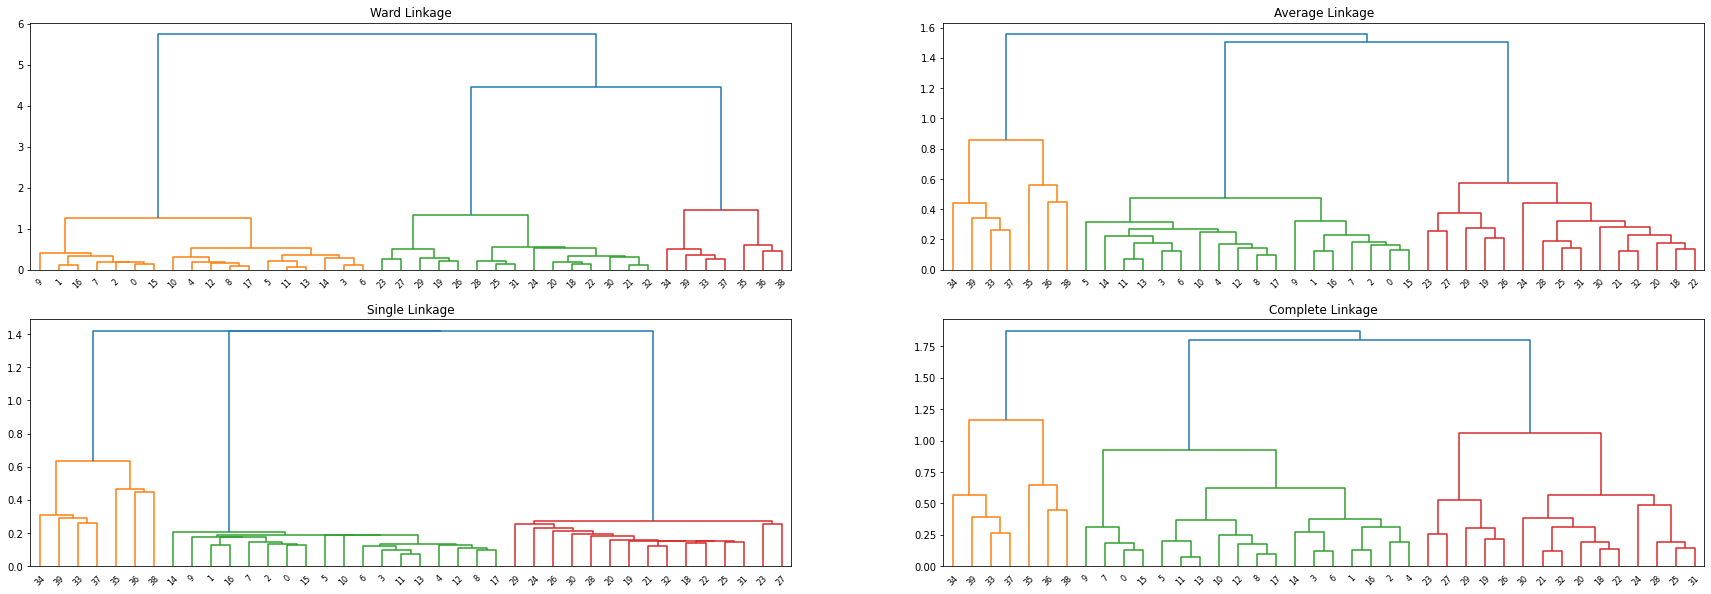

In [17]:
import scipy.cluster.hierarchy as shc
rows = 2
columns = 2
figure = plt.figure(figsize=(30, 10))  
figure.add_subplot(rows, columns, 1)
plt.title("Ward Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='ward'))
figure.add_subplot(rows, columns, 2)
plt.title("Average Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='average'))
figure.add_subplot(rows, columns, 3)
plt.title("Single Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='single'))
figure.add_subplot(rows, columns, 4)
plt.title("Complete Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='complete'))
figure.savefig('DendogramsFotoTeamsB1.png', dpi=300, bbox_inches='tight')


## Applying Hierarchical clustering for the clusters

In [35]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
team_models = cluster.fit_predict(data_scaled)

### <a name="UseCaseBClusterUnderstanding">3.2 Feature Selection and Understanding Clusters</a> 
[Back to Table of Contents](#table)

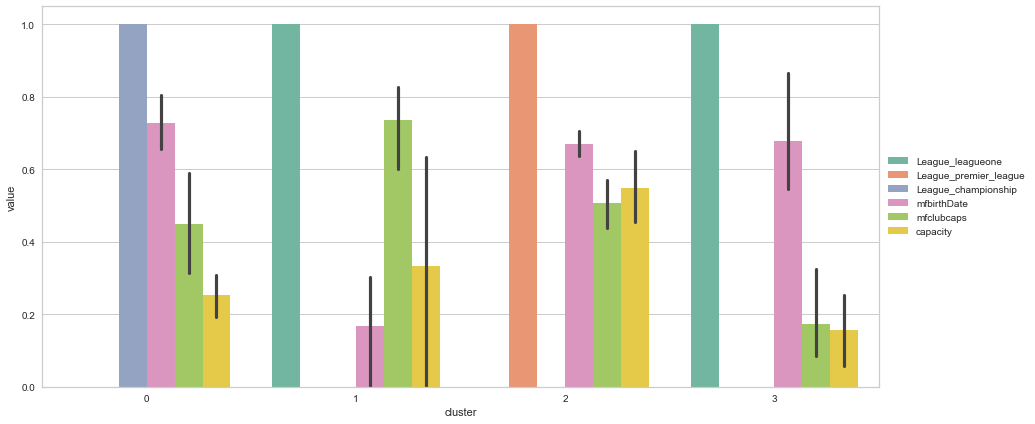

In [36]:
# Grouping rows of data based on Hierarchical cluster
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
minMaxscaler = MinMaxScaler()
scaledDataFrame = pd.DataFrame(minMaxscaler.fit_transform(df1_football_teams))
scaledDataFrame.columns = df1_football_teams.columns
scaledDataFrame['cluster'] = cluster.labels_
meansDataFrame = scaledDataFrame.groupby('cluster').mean().reset_index()
variablesDeviations = pd.DataFrame(columns=['Vars', 'Deviation'])
i = 0
while i < len(meansDataFrame.columns[1:]):
    variablesDeviations.loc[len(variablesDeviations), :] = [meansDataFrame.columns[1:][i], np.std(meansDataFrame[meansDataFrame.columns[1:][i]])]
    i+=1
includedColumns = list(variablesDeviations.sort_values('Deviation', ascending=False).head(10).Vars.values) + ['cluster']
finalData = scaledDataFrame[includedColumns].melt(id_vars='cluster')
figure, axix = plt.subplots(figsize=(15, 7))
sns.barplot(x='cluster', y='value', hue='variable', data=finalData, palette='Set2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('clustersFromFootTeamsB.png', dpi=300, bbox_inches='tight')

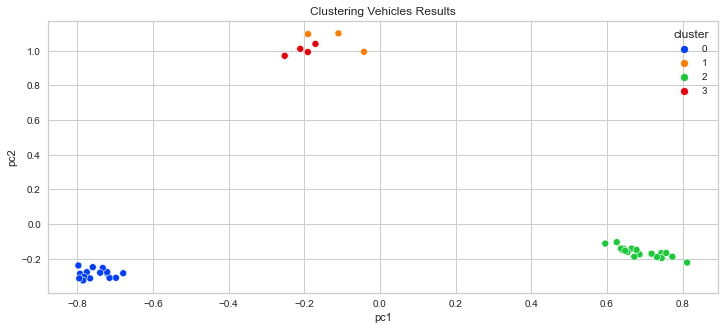

In [37]:
from sklearn.decomposition import PCA
fig, (sub1) = plt.subplots(1, figsize=(12, 5))
pca_vehicle_data = PCA(n_components=2)
principalComponents_vehicles = pca_vehicle_data.fit_transform(data_scaled)
sns.scatterplot(x=principalComponents_vehicles[:,0], y=principalComponents_vehicles[:,1], hue=team_models, palette='bright',ax=sub1);
sub1.set(xlabel="pc1", ylabel="pc2", title="Clustering Vehicles Results")
sub1.legend(title='cluster');
fig.savefig('PCAFootTeamsB1.png', dpi=300, bbox_inches='tight')


### <a name="UseCaseBSilhoutteResults">3.3 Analysing Cluster Results with Different linkage criteria and number of clusters</a> 
[Back to Table of Contents](#table)

In [38]:
sil_scores = []
dav_scores = []
calin_scores = []
n_clusters = []

for i in range(2,20):
    cluster1 = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='complete')  
    team_models1 = cluster1.fit_predict(data_scaled)
    hierarchical_clustering = pd.DataFrame(team_models1)
    dav_scores.append(davies_bouldin_score(data_scaled,hierarchical_clustering[0]))
    sil_scores.append(silhouette_score(data_scaled,hierarchical_clustering[0],metric='euclidean'))
    calin_scores.append(calinski_harabasz_score(data_scaled,hierarchical_clustering[0]))
    n_clusters.append(i)  
hierarchicial_clustering_results_df = {'Num Clusters': n_clusters,'Silhouette Score': sil_scores, 'Davies Bouldin Score': dav_scores,'Calinski Harabasz Score': calin_scores}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  Num Clusters &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0  &             2 &          0.415555 &              0.967859 &                16.225319 \\
1  &             3 &          0.709354 &              0.504648 &               108.673880 \\
2  &             4 &          0.692153 &              0.524495 &                95.421858 \\
3  &             5 &          0.588104 &              0.651456 &                97.272797 \\
4  &             6 &          0.416786 &              0.726673 &               101.594303 \\
5  &             7 &          0.394515 &              0.658569 &                91.048509 \\
6  &             8 &          0.323525 &              0.802679 &                89.390713 \\
7  &             9 &          0.288935 &              0.765518 &                83.109706 \\
8  &            10 &          0.223495 &              0.891075 &                79.975199 \\
9  &            11 &         

In [39]:
cluster1 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
team_models1 = cluster1.fit_predict(data_scaled)
hierarchical_clustering1 = pd.DataFrame(team_models1)
davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering1[0])
silhouette_score1 = silhouette_score(data_scaled,hierarchical_clustering1[0],metric='euclidean')
calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering1[0])

cluster2 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')  
team_models2 = cluster2.fit_predict(data_scaled)
hierarchical_clustering2 = pd.DataFrame(team_models2)
davies_bouldin_score2 = davies_bouldin_score(data_scaled,hierarchical_clustering2[0])
silhouette_score2 = silhouette_score(data_scaled,hierarchical_clustering2[0],metric='euclidean')
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,hierarchical_clustering2[0])

cluster3 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
team_models3 = cluster3.fit_predict(data_scaled)
hierarchical_clustering3 = pd.DataFrame(team_models3)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,hierarchical_clustering3[0])
silhouette_score3 = silhouette_score(data_scaled,hierarchical_clustering3[0],metric='euclidean')
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,hierarchical_clustering3[0])

cluster4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='single') 
team_models4 = cluster4.fit_predict(data_scaled)
hierarchical_clustering4 = pd.DataFrame(team_models4)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,hierarchical_clustering4[0])
silhouette_score4 = silhouette_score(data_scaled,hierarchical_clustering4[0],metric='euclidean')
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,hierarchical_clustering4[0])

hierarchicial_clustering_results_df = {'Linkage Type': ['Ward','Average','Complete','Single'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{llrrr}
\toprule
{} & Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &         Ward &          0.692153 &              0.524495 &                95.421858 \\
1 &      Average &          0.692153 &              0.524495 &                95.421858 \\
2 &     Complete &          0.692153 &              0.524495 &                95.421858 \\
3 &       Single &          0.692153 &              0.524495 &                95.421858 \\
\bottomrule
\end{tabular}



#### Determining the number of clusters for K-means Algorithm using Silhouette Visualizer

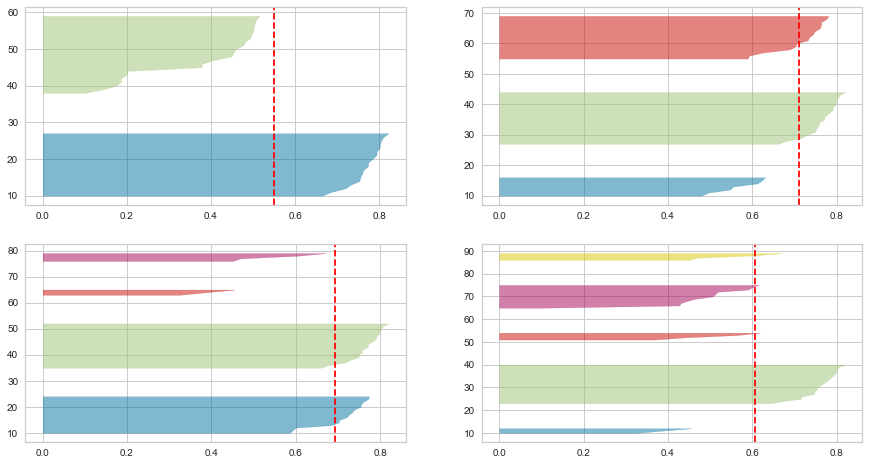

In [40]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled)

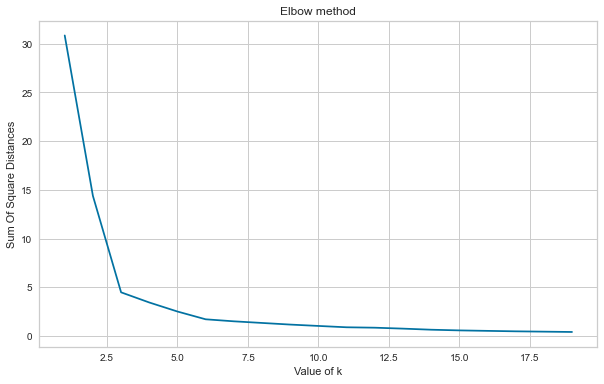

In [41]:
#Using Elbow Method when num clusters > 5
sum_of_squared_distances = []
cluster_range = range(1,20)
for cluster_num in cluster_range:
    kModel = KMeans(n_clusters=cluster_num)
    kModel.fit(data_scaled)
    sum_of_squared_distances.append(kModel.inertia_)
plt.figure(figsize=(10,6))
plt.plot(cluster_range, sum_of_squared_distances, 'bx-')
plt.xlabel('Value of k')
plt.ylabel('Sum Of Square Distances')
plt.title('Elbow method')
plt.show()

#### Criteria for DBSCAN

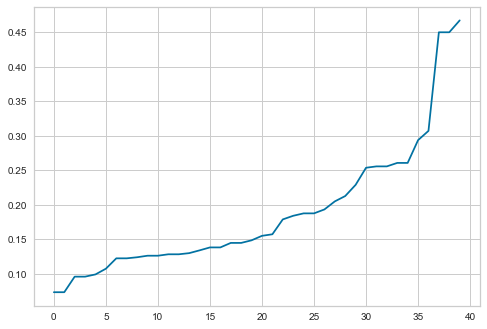

In [42]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#### Comparing the cell types

In [43]:
#Hierarchical clustering, K-means clustering with cosine k-means, .....
kmeans_norm = KMeans(n_clusters=4).fit(data_scaled)
dbs_data = DBSCAN(eps=0.3, min_samples=2).fit(data_scaled)

silhouette_score1 = silhouette_score(data_scaled, hierarchical_clustering3[0],metric='euclidean')
silhouette_score2 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='euclidean')
silhouette_score3 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='cosine')
silhouette_score4 = silhouette_score(data_scaled, dbs_data.labels_)

davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering3[0])
davies_bouldin_score2 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,dbs_data.labels_)

calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering3[0])
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,dbs_data.labels_)

clustering_results_df = {'Linkage Type': ['Agglomerative Hierarchical clustering(linkage = Average)','Kmeans','Cosine Based Kmeans','DBSCAN'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_of_results = pd.DataFrame(clustering_results_df)  
print(df_of_results.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &                                       Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &  Agglomerative Hierarchical clustering(linkage ... &          0.692153 &              0.524495 &                95.421858 \\
1 &                                             Kmeans &          0.692153 &              0.524495 &                95.421858 \\
2 &                                Cosine Based Kmeans &          0.895494 &              0.524495 &                95.421858 \\
3 &                                             DBSCAN &          0.638794 &              1.049680 &                76.861806 \\
\bottomrule
\end{tabular}



#### Latex Table of Rules For Clusters

In [44]:

dct_of_clusters = {"cluster numbers":[1,2,3,4],"cluster descriptions":["Championship Teams",
 "League One Teams where average birth year of midfielders is older than 1987",
 "Premier League Teams",
 "League One Teams where average birth year of midfielders is younger than 1987"]
}


df_of_results = pd.DataFrame(dct_of_clusters)  
print(df_of_results.to_latex())



\begin{tabular}{lrl}
\toprule
{} &  cluster numbers &                               cluster descriptions \\
\midrule
0 &                1 &                                 Championship Teams \\
1 &                2 &  League One Teams where average birth year of m... \\
2 &                3 &                               Premier League Teams \\
3 &                4 &  League One Teams where average birth year of m... \\
\bottomrule
\end{tabular}



### <a name="UseCaseBVisualization">3.4 Visualization of clusters for use case B</a> 
[Back to Table of Contents](#table)


In [45]:
import io
import sys

import folium

from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWebEngineWidgets import QWebEngineView 
from PyQt5.QtWebEngineWidgets import QWebEngineSettings as QWebSettings
from folium import IFrame

import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import collections, numpy
from matplotlib import animation
from pyclustertend import hopkins
from scipy import stats

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import folium

class Window(QtWidgets.QMainWindow):
    def __init__(self,dataset):
        self._dataset = dataset
        self._df_including_cordinates = self._dataset.copy()
        self._dataset.drop('longitude', inplace=True, axis=1)
        self._dataset.drop('latitude', inplace=True, axis=1)
        self._dataset.drop('clubname', inplace=True, axis=1)
        self._dataset.drop('mfheight', inplace=True, axis=1)
        super().__init__()
        self.initWindow()

    def initWindow(self):
        self.setWindowTitle(self.tr("Football Team Clusters For Midfielders-"))
        self.setFixedSize(1500, 800)
        self.comboBox1 = QtWidgets.QComboBox(self)
        self.editField2 = QtWidgets.QLineEdit(self)
        self.editField3 = QtWidgets.QLineEdit(self)
        self.editField4 = QtWidgets.QLineEdit(self)
        self.label5 = QtWidgets.QLabel('red',self)
        self.label5.setHidden(True)
        self.m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
        self.buttonUI()

    def buttonUI(self):
        submitButton = QtWidgets.QPushButton(self.tr("Submit"))
        submitButton.clicked.connect(self.calculateClusterPressed)
        self.comboBox1.setFixedSize(120, 50)
        self.comboBox1.addItem("Premier League")
        self.comboBox1.addItem("Championship")
        self.comboBox1.addItem("League One")
        self.editField2.setFixedSize(120, 50)
        self.editField3.setFixedSize(120, 50)
        self.editField4.setFixedSize(120, 50)
        submitButton.move(20, 260)
        label1 = QtWidgets.QLabel(self)
        label1.setText("League:")
        label1.setFixedSize(120, 50)
        label2 = QtWidgets.QLabel(self)
        label2.setText("MF's Birth Year:")
        label2.setFixedSize(120, 50)
        label3 = QtWidgets.QLabel(self)
        label3.setText("National Caps:")
        label3.setFixedSize(120, 50)
        label4 = QtWidgets.QLabel(self)
        label4.setText("Capacity:")
        label4.setFixedSize(120, 50)
        self.label5.setText("Data is an outlier")
        self.label5.setFixedSize(120, 50)
        self.label5.setStyleSheet("background-color: red")
        self.view = QWebEngineView()
        self.view.setContentsMargins(50, 50, 50, 50)
        central_widget = QtWidgets.QWidget()
        self.setCentralWidget(central_widget)
        lay = QtWidgets.QHBoxLayout(central_widget)
        button_container = QtWidgets.QWidget()
        vlay = QtWidgets.QVBoxLayout(button_container)
        vlay.setSpacing(20)
        vlay.addStretch()
        vlay.addWidget(label1)
        vlay.addWidget(self.comboBox1)
        vlay.addWidget(label2)
        vlay.addWidget(self.editField2)
        vlay.addWidget(label3)
        vlay.addWidget(self.editField3)
        vlay.addWidget(label4)
        vlay.addWidget(self.editField4)
        vlay.addWidget(submitButton)
        vlay.addWidget(self.label5)
        vlay.addStretch()
        lay.addWidget(button_container)
        lay.addWidget(self.view, stretch=1)
        data = io.BytesIO()
        self.m.save(data, close_file=False)
        self.view.setHtml(data.getvalue().decode())
    
    def calculateClusterPressed(self):        
        current_league = str(self.comboBox1.currentText())
        if current_league == "Premier League":
            prem_value = 1.0
            league_one = 0.0
            championship = 0.0
        elif current_league == "Championship":
            prem_value = 0.0
            league_one = 0.0
            championship = 1.0
        else:
            prem_value = 0.0
            league_one = 1.0
            championship = 0.0
        insertData = {'League_premier_league':prem_value, 'League_championship':championship,'League_leagueone':league_one,'mfbirthDate':self.editField2.text(),
                       'mfnationalcaps':self.editField3.text(), 'capacity':self.editField4.text() }
        self._dataset = self._dataset.append(insertData, ignore_index=True)
        
        df1_football_players = football_players_df
        scaler = MinMaxScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(self._dataset), columns=self._dataset.columns)
        cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
        team_models = cluster.fit_predict(data_scaled)
        hierarchical_clustering = pd.DataFrame(team_models)
        dct_of_popup = {0:"<b>Cluster 1: Championship Teams</b>", 1:"<b>Cluster 2: League One Teams where average birth year of midfielders is older than 1987</b>",2:"<b>Cluster 3: Premier League Teams</b>",3:"<b>Cluster 4: League One Teams where average birth year of midfielders is younger than 1987</b>"}
        dct_of_colour =  {0:"red", 1:"green",2:"blue",3:"orange"}
        new_item_cluster = team_models[-1]
        if np.count_nonzero(team_models == new_item_cluster) == 1:
            self.label5.setHidden(False)
        else:
            self.label5.setHidden(True)
            i = 0
            for index, row in self._df_including_cordinates.iterrows():
                if hierarchical_clustering[0][i] == team_models[-1]:
                    html="""
                    <h1>""" + str(row['clubname']) + """'s data</h1><br>
                    <b> Club Name: </b> """ + str(row['clubname']) + """ <br>
                    <b> League: </b> """ + current_league + """ <br>
                    <b> Stadium Capacity: </b> """ +  str(row['capacity']) + """ <br>
                    <b> Midfielders Average Height: </b> """ +  str(row['mfheight']) + """ <br>
                    <b> Forwards' Average Birth Date: </b> """ + str(row['mfbirthDate']) + """ <br>
                    <b> Forwards' Average National Caps: </b> """ + str(row['mfnationalcaps']) + """ <br>
                    """
                    frame = IFrame(html=html, width=500, height=300)
                    pop_text = folium.Popup(frame, max_width=2650)
                    folium.Marker(
                    [row['latitude'], row['longitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(self.m)
                i += 1
                self.m
                data = io.BytesIO()
                self.m.save(data, close_file=False)
                self.view.setHtml(data.getvalue().decode())
        
        
if __name__ == "__main__":
    football_teams_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet3_Teams_Midfielder_Stats")
    df1_football_players = edit_data_frame_with_columns_mf(['clubname','latitude','longitude','mfheight','league', 'mfbirthDate', 'mfnationalcaps', 'capacity'],football_teams_df)
    App = QtCore.QCoreApplication.instance()
    if App is None:
        App = QtWidgets.QApplication(sys.argv)
    window = Window(df1_football_players)
    window.show()
    sys.exit(App.exec())


SystemExit: 0

/Users/colmclery/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### <a name="UseCaseBTimeExperiment">3.5 Experimenting Time To Load Cluster items</a> 
[Back to Table of Contents](#table)

In [ ]:
import time
num_clusters = 4
affin = 'euclidean'
link = 'complete'
football_teams_df = pd.read_excel("football_team_stats.xlsx", sheet_name="Sheet3_Teams_Midfielder_Stats")
df1_football_teams = edit_data_frame_with_columns_mf(['clubname','latitude','longitude','mfheight','league', 'mfbirthDate', 'mfnationalcaps', 'capacity'],football_teams_df)
df1_football_teams_copy = df1_football_teams.copy()
df1_football_teams.drop('longitude', inplace=True, axis=1)
df1_football_teams.drop('latitude', inplace=True, axis=1)
df1_football_teams.drop('clubname', inplace=True, axis=1)
df1_football_teams.drop('mfheight', inplace=True, axis=1)
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df1_football_teams), columns=df1_football_teams.columns)
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity=affin, linkage=link) 
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
data_scaled.insert((data_scaled.shape[1]),'agglomerative',hierarchical_clustering)
dct_of_colour =  {0:"red", 1:"green",2:"blue",3:"orange"}
times_dct = {"Cluster ID":[],"Number Of Teams":[],"Time To Load":[],}
m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
cluster_id = 0
for cluster in range(num_clusters):
    i = 0
    t1 = time.time()
    count_per_cluster = 0
    for index, row in df1_football_teams_copy.iterrows():                       
        if team_models[i] == cluster_id:
            count_per_cluster += 1
            html="""
                    <h1>""" + str(row['clubname']) + """'s data</h1><br>
                    <p>
                    </p>
                    <b> Club Name: </b> """ + str(row['clubname']) + """ <br>
                    <b> Stadium Capacity: </b> """ +  str(row['capacity']) + """ <br>
                    <b> Midfielders Average Height: </b> """ +  str(row['mfheight']) + """ <br>
                    <b> Forwards' Average Birth Date: </b> """ + str(row['mfbirthDate']) + """ <br>
                    <b> Forwards' Average National Caps: </b> """ + str(row['mfnationalcaps']) + """ <br>
                    """
            frame = IFrame(html=html, width=500, height=300)
            pop_text = folium.Popup(frame, max_width=2650)
            folium.Marker(
                    [row['latitude'], row['longitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(m)
        i += 1
    t2 = time.time()
    times_dct["Time To Load"].append(t2 - t1)
    cluster_id+=1
    times_dct["Number Of Teams"].append(count_per_cluster)
    times_dct["Cluster ID"].append(cluster_id)
df = pd.DataFrame(times_dct)
print(df.to_latex())
data = io.BytesIO()
m.save(data, close_file=False)
m



